This is a simple test quickstart on the overall library as currently avalaible on Github

``` This specifically shows that midcircuit measure does not work as is ```

In [6]:
import os
os.chdir("/Users/cherie/Desktop/quantum-gates/src")  # or any folder that actually exists
print(os.getcwd())

/Users/cherie/Desktop/quantum-gates/src


In [7]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

# 0) Point to the *parent* of the package folder
LOCAL_QG_PATH = r"../src"   # or r"C:\Users\npace\Desktop\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# 1) Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# 2) Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# 3) Invalidate import caches and import the local package
importlib.invalidate_caches()
print(os.getcwd())
import quantum_gates

print("Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import SurfaceCode
    
    


/Users/cherie/Desktop/quantum-gates/src
Using quantum_gates from: /Users/cherie/Desktop/quantum-gates/src/quantum_gates/__init__.py


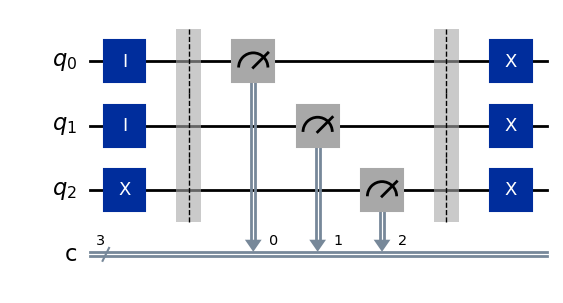

In [19]:
N_q = 3
qc = QuantumCircuit(3,3)
qc.id(0)
qc.id(1)
qc.x(2)

qc.barrier()
qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)
qc.barrier()

qc.x(0)
qc.x(1)
qc.x(2)

qc.draw("mpl")    

In [20]:
# -------------------------------
# 1️⃣ Setup simulator and initial state
# -------------------------------

bit_flip_bool = False

sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

shots = 10

# -------------------------------
# 2️⃣ Create and load the fake backend
# -------------------------------

# dump_from_fake_backend.py
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters

# Pick a fake backend
backend = FakeBrisbane()  # 127 qubits; change to another Fake*V2 if import fails



needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=list(range(N_q)),
    seed_transpiler=42,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

print(f"Original circuit qubits: {qc.num_qubits}")
print(f"Transpiled circuit qubits: {t_circ.num_qubits}")
print(f"N_q: {N_q}")

# Check which qubits are actually used in transpiled circuit
used_qubits: list[int] = []
for instr in t_circ.data:
    op = instr.operation
    if op.name == 'delay':
        continue
    # support any arity
    for qb in instr.qubits:
        q = qb._index
        if q not in used_qubits:
            used_qubits.append(q)
            
print(f"Qubits used in transpiled circuit: {sorted(used_qubits)}")

max_qubit = max(used_qubits)
nqubit_actual = max_qubit + 1

initial_psi = np.zeros(2**nqubit_actual)

initial_psi[0] = 1.0  # set |00...0⟩

qubits_layout = list(range(nqubit_actual))

#  Load via YOUR class and save JSON next to the script
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()
device_param.save_to_json("./")  # writes ./device_parameters.json
print("Wrote ./device_parameters.json")

res  = sim.run( 
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=initial_psi, 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=nqubit_actual,
    bit_flip_bool=bit_flip_bool,
    )

probs = res["probs"]
results = res["results"]
num_clbits = res["num_clbits"]
mid_counts = res["mid_counts"]


print("Mid-circuit measurement results", results)
#print("Final measurement counts:", final_counts)
#print("Final measurement probabilities:", probs)
print("Number of classical bits in circuit:", num_clbits)
print("Mid-circuit measurement counts:", mid_counts)
print("Final probabilities:", probs)



Original circuit qubits: 3
Transpiled circuit qubits: 127
N_q: 3
Qubits used in transpiled circuit: [0, 1, 2]
Device parameters are valid. We can save them. 
Device parameters saved successfully.
Wrote ./device_parameters.json
Inferred nqubit from psi0: 3
---- Preprocessed data ----
Chunk 0: delay[0] , delay[1] , x[2]
Fancy 1: mid_measurement qubits=[0] clbits=[0]
Fancy 2: mid_measurement qubits=[1] clbits=[1]
Fancy 3: mid_measurement qubits=[2] clbits=[2]
Chunk 4: x[0] , x[1] , x[2]
---------------------------
Layout mapping (phys→virt): [2, 0, 1]

 X -GATE on qubit 2 with p = 0.00033534112767932513 , T1 = 0.000225591023977547 , T2 = 0.0002455670149680726
Input statevector dimensions: (8,)
Number of matrix products: 3

 X -GATE on qubit 0 with p = 0.00024329590602476677 , T1 = 0.00023736364020705798 , T2 = 4.942561173908419e-05

 X -GATE on qubit 1 with p = 0.0002425970240311255 , T1 = 0.00015845256790461264 , T2 = 0.00024205529344696424

 X -GATE on qubit 2 with p = 0.000335341127679

In [3]:
# Standard libraries
import numpy as np
import json
import os
from dotenv import load_dotenv

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit_ibm_runtime import QiskitRuntimeService


# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend



In [4]:
load_dotenv()  # loads .env file into environment

IBM_TOKEN = os.getenv("IBM_TOKEN")
CRN = os.getenv("CRN")

In [5]:
def service(ibm_token: str):
    """
    Connect to IBM Quantum service and list available backends.
    
    Parameters
    ----------
    ibm_token : str
        Your IBM Quantum API token.
    """
    backends=[]
    try:
        svc = QiskitRuntimeService(channel="ibm_quantum_platform", token=ibm_token)

        print("✅ Connected to IBM Quantum")
        print("Available backends:")
        for backend in svc.backends():
            print(f" - {backend.name}")
            backends.append(backend.name)
        return backends

    except Exception as e:
        print("❌ Failed to connect to IBM Quantum service.")
        print(f"Reason: {e}")
        return None
    

In [4]:
available_backends = service(IBM_TOKEN)
backend_name = available_backends[0]  # Select the first available backend


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-11-02 14:38:02,292: Default instance not set. Searching all available instances.


✅ Connected to IBM Quantum
Available backends:
 - ibm_brisbane
 - ibm_fez
 - ibm_torino
 - ibm_marrakesh


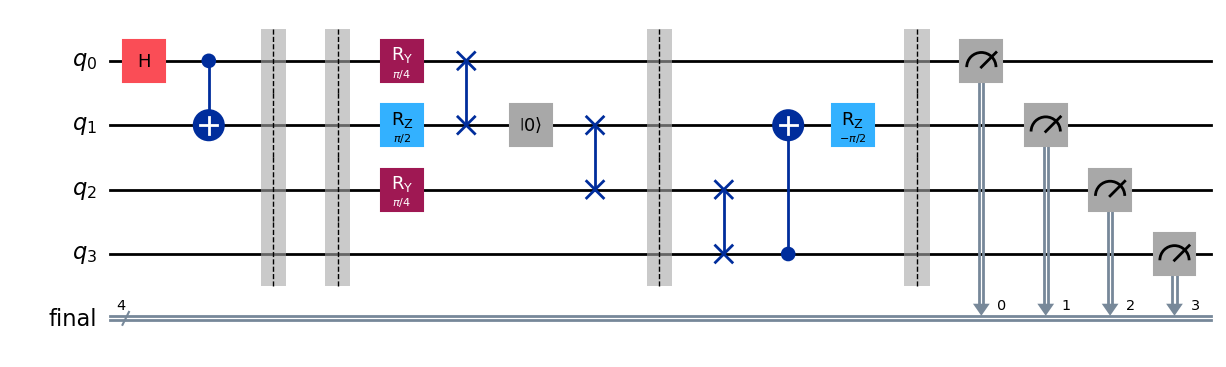

In [5]:

# Create explicit quantum and classical registers
N_q = 4
N_mid = 1
qreg = QuantumRegister(N_q, "q")
#mid = ClassicalRegister(N_mid, "mid")
final = ClassicalRegister(N_q, "final")

# Build the circuit
qc = QuantumCircuit(qreg, final)
# 1) Create a Bell state
qc.h(0)
qc.cx(0, 1)
qc.barrier()

# 2) Mid-circuit measure of qubit 0 into cbit 0
#qc.measure(0, 0)
qc.barrier()

# 3) Conditionally flip qubit 1 if the measurement was 1 (new control-flow API)
'''with qc.if_test((qc.clbits[0], 1)):
    qc.x(1)'''
qc.rz(np.pi/2, 1)
qc.ry(np.pi/4, 0)
qc.swap(0,1)
qc.ry(np.pi/4, 2)
qc.reset(1)
qc.swap(1,2)
qc.barrier()
qc.swap(2,3)
qc.cx(3,1)
qc.rz(-np.pi/2, 1)

qc.barrier()
# 4) Final measurement
qc.measure(range(N_q), final)

qc.draw("mpl")


In [6]:

sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

# Number of qubits in the code
cycles = 2
initial_psi = np.zeros(2**N_q)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(N_q))  # logical qubit 0→physical 0, 1→1, etc.
shots = 2

In [7]:
config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": backend_name,
        "crn": CRN
    },
    "run": {
        "shots": shots,
        "qubits_layout": initial_layout,
        "psi0": initial_psi
    }
}

In [8]:
backend_config = config["backend"]
backend = setup_backend(Token=IBM_TOKEN, **backend_config)
run_config = config["run"]

In [9]:
qubits_layout = run_config["qubits_layout"]
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()

In [10]:


needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

probs = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(run_config["psi0"]), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=N_q,
    )



c:\Users\npace\AppData\Local\Programs\Python\Python312\Lib\site-packages\quantum_gates\_gates\factories.py:157: RuntimeWarning: invalid value encountered in sqrt
  ep = np.sqrt((1/2) * (e2**2 - e1**2/2))
c:\Users\npace\AppData\Local\Programs\Python\Python312\Lib\site-packages\quantum_gates\_gates\factories.py:97: RuntimeWarning: invalid value encountered in sqrt
  ep = np.sqrt((1/2) * (e2**2 - e1**2/2))
c:\Users\npace\AppData\Local\Programs\Python\Python312\Lib\site-packages\quantum_gates\_gates\factories.py:442: RuntimeWarning: invalid value encountered in sqrt
  ep_ctr = np.sqrt((1/2) * (e2_ctr**2 - e1_ctr**2/2))
c:\Users\npace\AppData\Local\Programs\Python\Python312\Lib\site-packages\quantum_gates\_gates\factories.py:453: RuntimeWarning: invalid value encountered in sqrt
  ep_trg = np.sqrt((1/2) * (e2_trg**2 - e1_trg**2/2))


AssertionError: Found unphysical probability vector [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan].

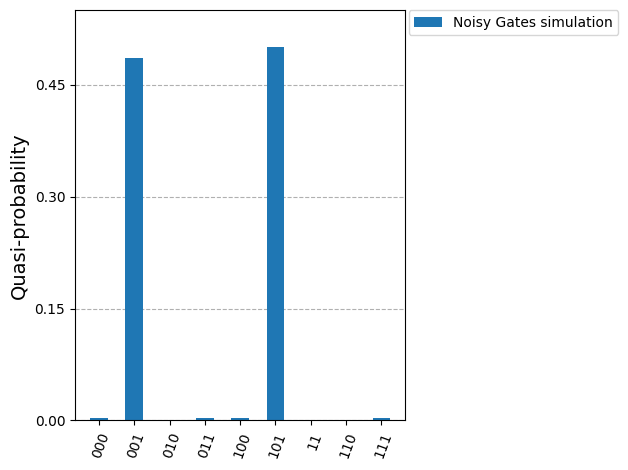

In [ ]:
n_classic_bit = 2

measured_qubit = n_classic_bit
counts_ng = fix_counts(probs, measured_qubit)
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

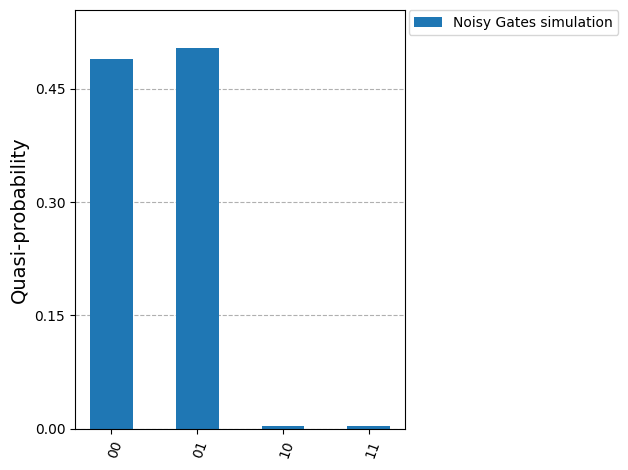

In [ ]:

def keep_last_n_bits(counts, n):
    """Return a new counts dict with only the last n bits of each key."""
    new_counts = {}
    for bitstring, value in counts.items():
        final_bits = bitstring[-n:]  # take last n bits
        new_counts[final_bits] = new_counts.get(final_bits, 0) + value
    return new_counts

# Example usage
counts_final = keep_last_n_bits(probs, 2)
plot_histogram(counts_final, bar_labels=False, legend=['Noisy Gates simulation'])


Comparison with AER

In [ ]:
# Simulate with Aer
sim = AerSimulator()
t_qc = transpile(qc, sim)
result = sim.run(t_qc, shots=2048).result()
counts = result.get_counts()

Measurement counts: {'101': 1023, '001': 1025}


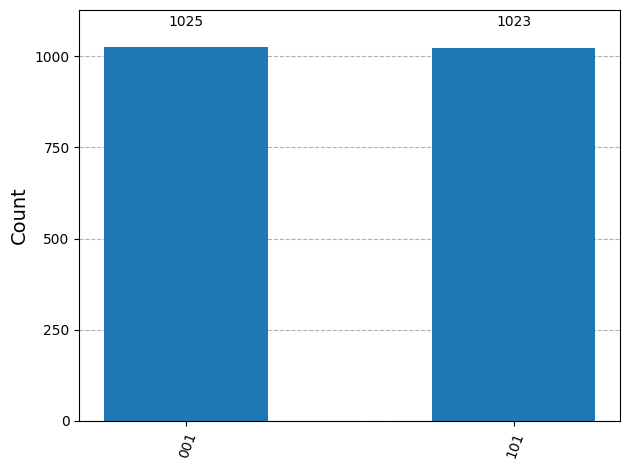

In [ ]:
print("Measurement counts:", counts)
plot_histogram(counts)

Truncated to final 2 bits: {'01': 1027, '11': 1021}


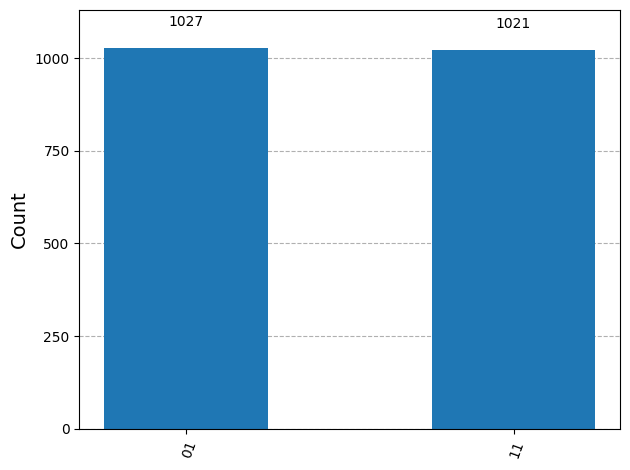

In [ ]:
# Keep only the last 2 classical bits
final_counts = marginal_counts(counts, indices=[0, 1])

print("Truncated to final 2 bits:", final_counts)
plot_histogram(final_counts)